In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In this tutorial I will focus on these 3 different strategies : 
1. 1- Bag-of-words( with Tf-Idf) : used with simple machine learning algorithm 
1. 2-Word Embedding (with Word2vec) : used with deep learning neural network 
1. 3- Bert : used with transfer learning from attention-based transformers. 


NLP : it is about programming computers to process and analyze large amounts of natural language data. 

In [2]:
#First of all, I need to import the following libraries:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
dtf = pd.read_csv("../input/nlp-getting-started/train.csv")

the univariate distribution of the target : the labels frequency with a bar plot. 

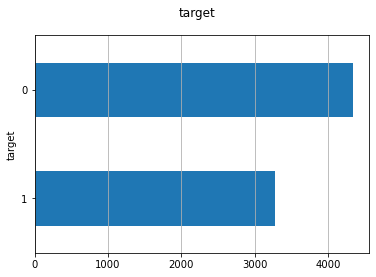

In [4]:
fig, ax = plt.subplots()
fig.suptitle("target", fontsize=12)
dtf["target"].reset_index().groupby("target").count().sort_values(by= "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show() 

the dataset is balanced 

Before explaining and building the models, I am going to give an example of preprocessing by cleaning text, removing stop words, and applying lemmatization. I will write a function and apply it to the whole data set.

In [5]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   
    #characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

So let's apply the function and store the result in a new column named 'text_clean' 

In [7]:
dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [8]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["target"].values
y_test = dtf_test["target"].values

# Bag-of-Words******

So Bag of words works like this  : it builds a vocabulary from a corpus of documents and then counts how many times the words appear in each document. 
so each word becomes a feature and a  document is represented by a vector with the same lenghth of the vocabulary. 
*the Feature matrix shape = Number of documents * length of vocabulary.*

As you can image , this approach causes  a huge sparse matrix ; a significant dimensionality problem : the more documents you have the larger is the vocabulary. That's why the bag of words model is usually preceded by an important preprocessing (word claning , stop words removals , stemming/lemmatization) aimed to reduce the dimensionnality problem. 

I skipped the part of TFIDF ! I will expalain it later 

So after splitting the data we will focus now on ***Feature Engineering***, which is the process of creating features by extracting information from the data. I am going to use the Tf-Idf vectorizer with a limit of 10,000 words (so the length of my vocabulary will be 10k), capturing unigrams (i.e. “new” and “york”) and bigrams (i.e. “new york”) #if we use trigrams it will be for example "new york city". I will provide the code for the classic count vectorizer as well:

In [9]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [10]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In order to know the position of a certain word, we can look it up in the vocabulary:


In [11]:
word = "forest"
dic_vocabulary[word]
#If the word exists in the vocabulary, 
#this command prints a number N, 
#meaning that the Nth feature of the matrix is that word.

3031

**reduce the matrix dimensionality****
in order to reduce the dimensionality of our matrix ! [Feature matrix shape: Number of documents x Length of vocabulary ] we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:
* treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);
1. perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
1. keep only the features with a certain p-value from the Chi-Square test.

In [12]:
from sklearn import feature_selection 
y = dtf_train["target"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()
len(X_names)

237

In [13]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# 0:
  . selected features: 237
  . top features: hiroshima,california,fire,mh370,suicide,wildfire,bombing,killed,im,northern
 
# 1:
  . selected features: 237
  . top features: hiroshima,california,fire,mh370,suicide,wildfire,bombing,killed,im,northern
 


#training the model ! 
Naive Bayes algorithm: a probabilistic classifier that makes use of Bayes’ Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. 

In [14]:
classifier = naive_bayes.MultinomialNB()

I’m going to train this classifier on the feature matrix and then test it on the transformed test set. To that end, I need to build a scikit-learn pipeline: a sequential application of a list of transformations and a final estimator. Putting the Tf-Idf vectorizer and the Naive Bayes classifier in a pipeline allows us to transform and predict test data in just one step.

In [15]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

We can now evaluate the performance of the Bag-of-Words model, I will use the following metrics:****

**Accuracy** is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition:
Accuracy in Machine Learning
The accuracy of a machine learning classification algorithm is one way to measure how often the algorithm classifies a data point correctly. Accuracy is the number of correctly predicted data points out of all the data points. More formally, it is defined as the number of true positives and true negatives divided by the number of true positives, true negatives, false positives, and false negatives. A true positive or true negative is a data point that the algorithm correctly classified as true or false, respectively. A false positive or false negative, on the other hand, is a data point that the algorithm incorrectly classified. For example, if the algorithm classified a false data point as true, it would be a false positive. Often, accuracy is used along with precision and recall, which are other metrics that use various ratios of true/false positives/negatives. Together, these metrics provide a detailed look at how the algorithm is classifying data points. 

Example
Consider a classification algorithm that decides whether an email is spam or not. The algorithm is trained, and we want to see how well it performs on a set of ten emails it has never seen before. Of the ten emails, six are not spam and four are spam. The algorithm classifies three of the messages as spam, of which two are actually spam, and one is not spam. In the table, the true positives (the emails that are correctly identified as spam) are colored in green, the true negatives (the emails that are correctly identified as not spam) are colored in blue, the false positives (the not spam emails that are incorrectly classified as spam) are colored in red, and the false negatives (the spam emails that are incorrectly identified as not spam) are colored in orange. There are two true positives, five true negatives, two false negatives, and one false positive. Using the formula for accuracy, we get: 

This algorithm has 70% accuracy classifying emails as spam or not. 
![](https://images.deepai.org/django-summernote/2019-05-09/ad392084-735b-432a-bdf0-b4b56a455de3.jpg)


What is a **Confusion Matrix**?
The million dollar question – what, after all, is a confusion matrix?

A **Confusion matrix** is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. This gives us a holistic view of how well our classification model is performing and what kinds of errors it is making.

For a binary classification problem, we would have a 2 x 2 matrix as shown below with 4 values:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/04/Basic-Confusion-matrix.png) 


**AUC - ROC** curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.
The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
![](https://miro.medium.com/max/361/1*pk05QGzoWhCgRiiFbz-oKQ.png) 

Precision is how close measure values are to each other, basically how many decimal places are at the end of a given measurement.  Precision does matter.  Accuracy is how close a measure value is to the true value.  Accuracy matters too, but it’s best when measurements are both precise and accurate.

Failure to understand the tension between precision and accuracy can have profound negative effects on how one processes data, and the final outcome of geospatial analysis.

![](https://i0.wp.com/wp.stolaf.edu/it/files/2017/06/precsionvsaccuracy_crashcourse.png?resize=579%2C600&ssl=1) 

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

Recall = True Positives / (True Positives + False Negatives)
1
Recall = True Positives / (True Positives + False Negatives)



Credits to : 
1. 1- https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/ 
1. 2- https://deepai.org/researchers 
1. 3- https://wp.stolaf.edu/it/gis-precision-accuracy/ 
1. 4- https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5 

1. 5 https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/